In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, precision_recall_fscore_support
)

In [2]:
#uvoz skupa podataka

df = pd.read_csv('../freMTPL2freq.csv')
df = df.sample(n=100000, random_state=42)
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
261354,2122523.0,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
448143,3173420.0,0,0.10,D,7,17,80,95,B2,Regular,598,R25
188618,1188619.0,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
12952,31400.0,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
425028,3138755.0,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53


In [3]:
df.shape

(100000, 12)

In [4]:
df.isna().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [5]:
df.duplicated().sum() #nemamo duplikata u skupu

0

In [6]:
# izvaci redove gde je ClaimNb veca od 4
df = df[df['ClaimNb'] <= 4]

In [7]:
# Nova kolona: da li je vozač imao bar jednu štetu
df['ClaimNb'] = df['ClaimNb'].apply(lambda x: 1 if x > 0 else 0)

In [8]:
# Izbor karakteristika i enkodiranje kategorijskih atributa
# Ukloni IDpol i ClaimNb iz features
features = ['DrivAge', 'VehAge', 'VehPower', 'Density', 'Exposure', 'BonusMalus', 'VehPower', 'BonusMalus', 'Area']

X = df[['DrivAge', 'VehPower', 'BonusMalus', 'Area', 'Density']]
X = pd.get_dummies(X, columns=['VehPower', 'BonusMalus', 'Area'])


y = df['ClaimNb']

In [9]:
X.describe()

,DrivAge,Density
count,99999.000000,99999.000000
mean,45.519965,1798.086511
std,14.147228,3949.520250
min,18.000000,2.000000
25%,34.000000,93.000000
50%,44.000000,393.000000
75%,55.000000,1662.000000
max,99.000000,27000.000000


In [10]:
# Podela podataka na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [11]:
#zbog velike nebalansiranosti klasa
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [12]:
# Definisanje modela
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [13]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [14]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [15]:
# Predikcije
y_pred_knn = knn.predict(X_test)
y_pred_dtc = dtc.predict(X_test)
y_pred_nb = nb.predict(X_test)

In [16]:
# Funkcija za evaluaciju
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return acc, prec, rec, f1

In [17]:
# Evaluacija svih modela
results = {}
results['KNN'] = evaluate_model(y_test, y_pred_knn)
results['Decision Tree'] = evaluate_model(y_test, y_pred_dtc)
results['Naive Bayes'] = evaluate_model(y_test, y_pred_nb)

In [18]:
print("Matrica konfuzije za KNN:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nMatrica konfuzije za Decision Tree:")
print(confusion_matrix(y_test, y_pred_dtc))

print("\nMatrica konfuzije za Naive Bayes:")
print(confusion_matrix(y_test, y_pred_nb))

Matrica konfuzije za KNN:
[[18103 10398]
 [  904   595]]

Matrica konfuzije za Decision Tree:
[[26787  1714]
 [ 1370   129]]

Matrica konfuzije za Naive Bayes:
[[14387 14114]
 [  718   781]]


In [19]:
# Kreiranje tabele sa rezultatima
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-score']).T

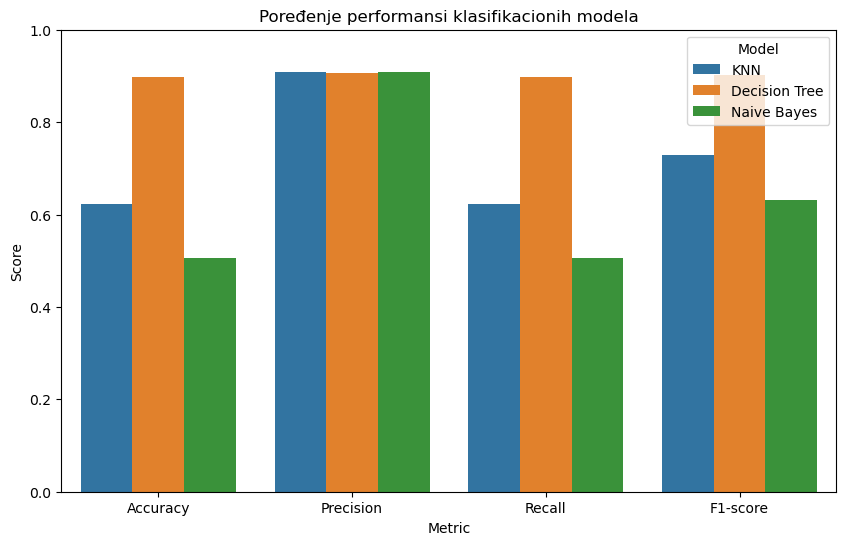

In [20]:
# Pretvori DataFrame u "long format" za lakšu vizualizaciju
results_long = results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
results_long.rename(columns={'index': 'Model'}, inplace=True)

plt.figure(figsize=(10,6))
sns.barplot(x='Metric', y='Score', hue='Model', data=results_long)
plt.title('Poređenje performansi klasifikacionih modela')
plt.ylim(0, 1)  # jer su metrike između 0 i 1
plt.legend(title='Model')
plt.show()

In [21]:
print("Tabela performansi modela:\n")
print(results_df)

Tabela performansi modela:

               Accuracy  Precision    Recall  F1-score
KNN            0.623267   0.907553  0.623267  0.728783
Decision Tree  0.897200   0.907306  0.897200  0.902179
Naive Bayes    0.505600   0.907494  0.505600  0.631653


In [22]:
# Provera predikcija i evaluacija
print("Decision Tree:")
print(evaluate_model(y_test, y_pred_dtc))

print("KNN:")
print(evaluate_model(y_test, y_pred_knn))

print("Naive Bayes:")
print(evaluate_model(y_test, y_pred_nb))

# Kreiranje results_df
results_df = pd.DataFrame({
    'Decision Tree': evaluate_model(y_test, y_pred_dtc),
    'KNN': evaluate_model(y_test, y_pred_knn),
    'Naive Bayes': evaluate_model(y_test, y_pred_nb)
}).T

print(results_df)

Decision Tree:
(0.8972, 0.9073061429314904, 0.8972, 0.9021786481527357)
KNN:
(0.6232666666666666, 0.9075528578976028, 0.6232666666666666, 0.728783339910246)
Naive Bayes:
(0.5056, 0.9074944535037773, 0.5056, 0.6316529129946654)
                      0         1         2         3
Decision Tree  0.897200  0.907306  0.897200  0.902179
KNN            0.623267  0.907553  0.623267  0.728783
Naive Bayes    0.505600  0.907494  0.505600  0.631653


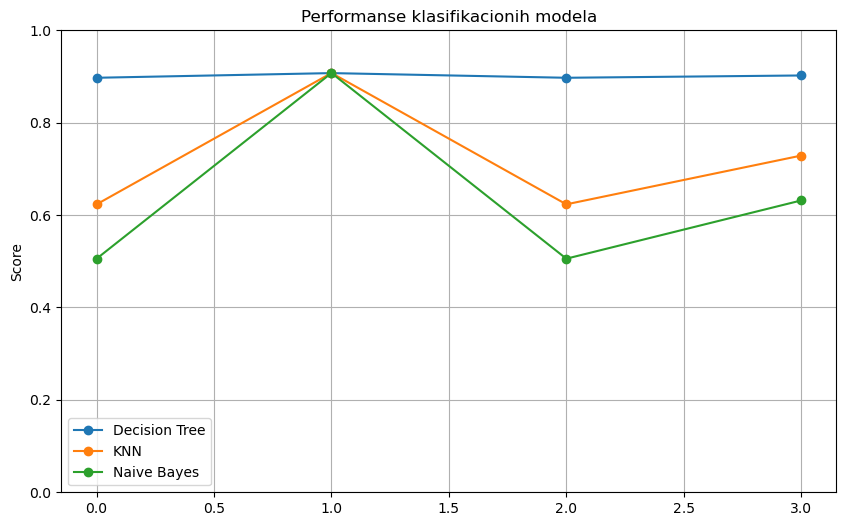

In [23]:
plt.figure(figsize=(10,6))
for model in results_df.index:
    plt.plot(results_df.columns, results_df.loc[model], marker='o', label=model)

plt.title('Performanse klasifikacionih modela')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

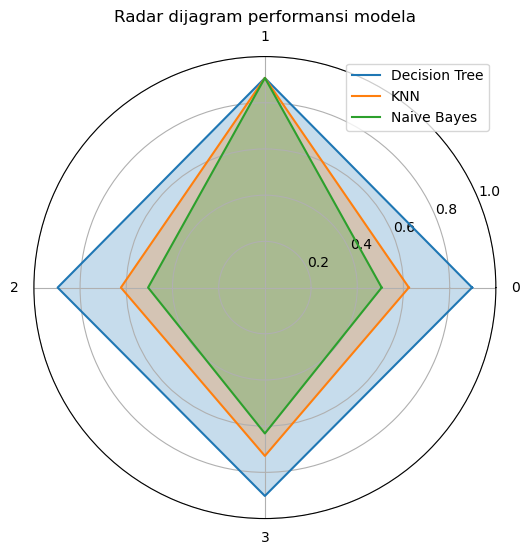

In [24]:
labels=np.array(results_df.columns)
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, model in enumerate(results_df.index):
    values = results_df.loc[model].tolist()
    values += values[:1]
    ax.plot(angles, values, label=model)
    ax.fill(angles, values, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
plt.title('Radar dijagram performansi modela')
plt.legend(loc='upper right')
plt.show()


c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


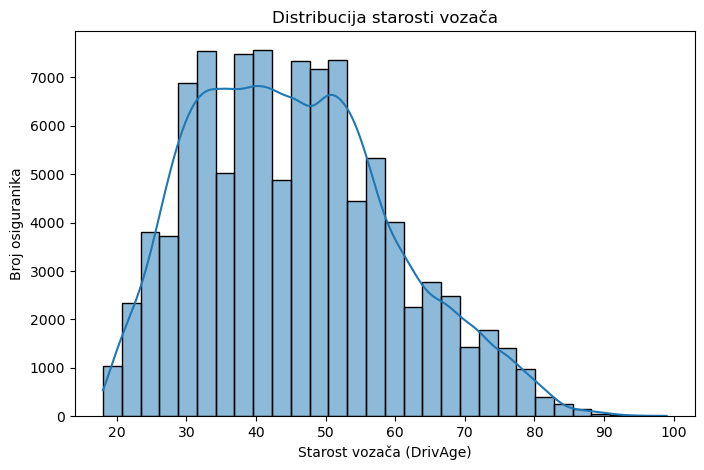

In [25]:
#Histogram starosti

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='DrivAge', bins=30, kde=True)
plt.title('Distribucija starosti vozača')
plt.xlabel('Starost vozača (DrivAge)')
plt.ylabel('Broj osiguranika')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5220\4129659659.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupe = df.groupby('starosna_grupa')['nezgoda'].mean().reset_index()
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


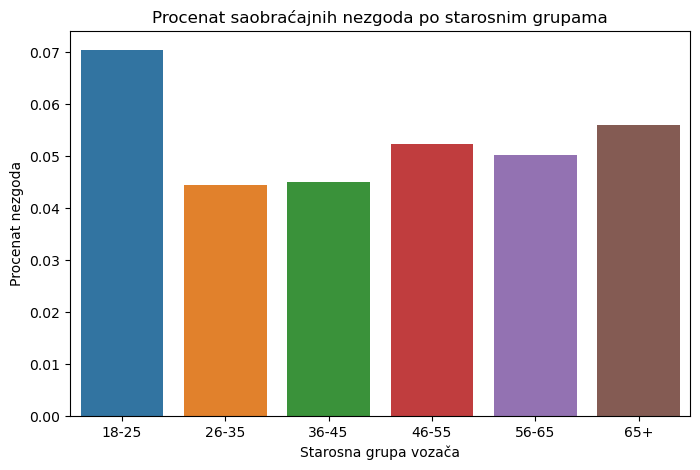

In [26]:
df['nezgoda'] = df['ClaimNb'].apply(lambda x: 1 if x > 0 else 0)

df['starosna_grupa'] = pd.cut(df['DrivAge'], bins=[18,25,35,45,55,65,100], labels=['18-25','26-35','36-45','46-55','56-65','65+'])

grupe = df.groupby('starosna_grupa')['nezgoda'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=grupe, x='starosna_grupa', y='nezgoda')
plt.title('Procenat saobraćajnih nezgoda po starosnim grupama')
plt.xlabel('Starosna grupa vozača')
plt.ylabel('Procenat nezgoda')
plt.show()

c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


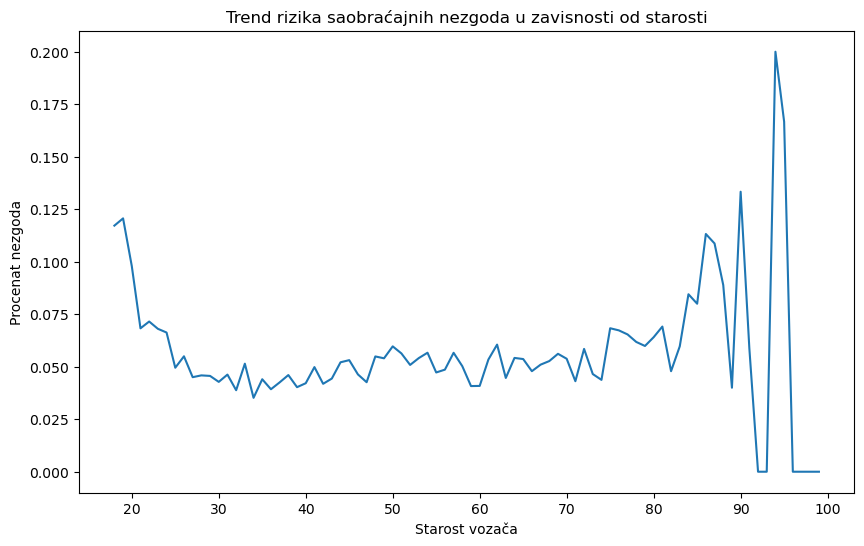

In [27]:
starost_nezgoda = df.groupby('DrivAge')['nezgoda'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=starost_nezgoda, x='DrivAge', y='nezgoda')
plt.title('Trend rizika saobraćajnih nezgoda u zavisnosti od starosti')
plt.xlabel('Starost vozača')
plt.ylabel('Procenat nezgoda')
plt.show()

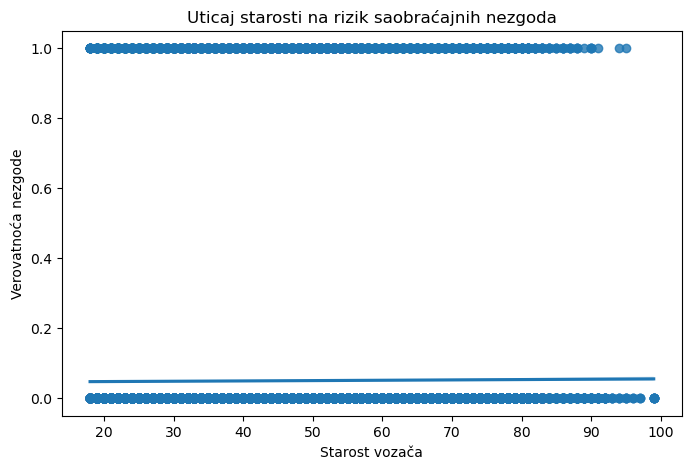

In [28]:
plt.figure(figsize=(8,5))
sns.regplot(data=df, x='DrivAge', y='nezgoda', logistic=True)
plt.title('Uticaj starosti na rizik saobraćajnih nezgoda')
plt.xlabel('Starost vozača')
plt.ylabel('Verovatnoća nezgode')
plt.show()

In [31]:
models = {
    'Decision Tree': dtc,
    'KNN': knn,
    'Naive Bayes': nb
}


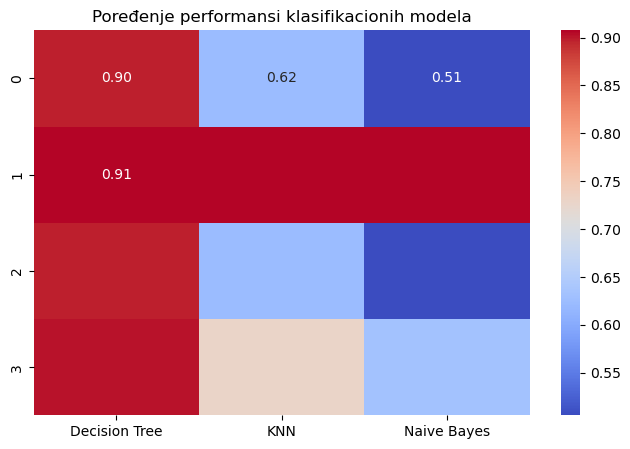

In [34]:
plt.figure(figsize=(8,5))
sns.heatmap(results_df.T, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Poređenje performansi klasifikacionih modela')
plt.show()


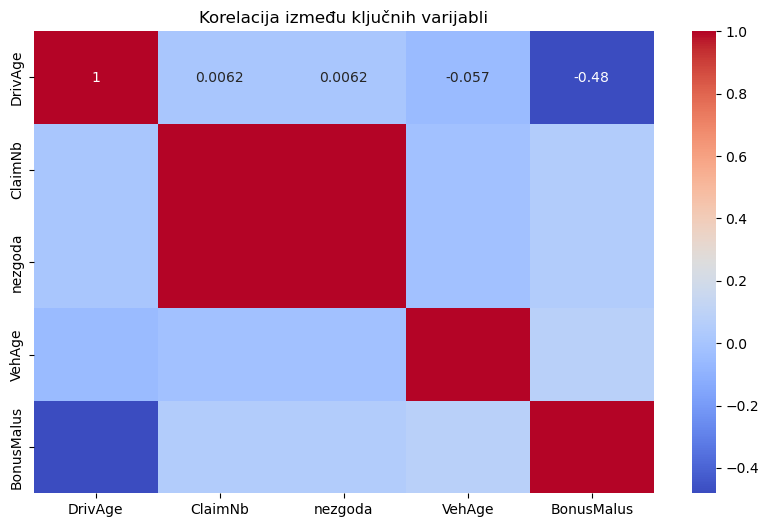

In [35]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['DrivAge', 'ClaimNb', 'nezgoda', 'VehAge', 'BonusMalus']].corr(), annot=True, cmap='coolwarm')
plt.title('Korelacija između ključnih varijabli')
plt.show()

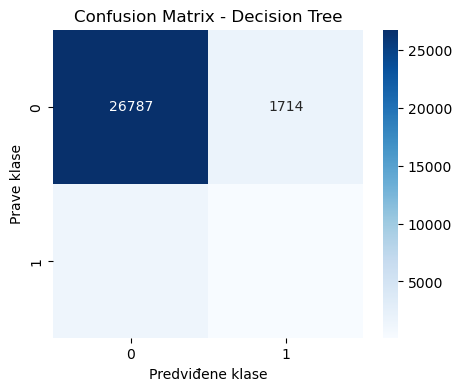

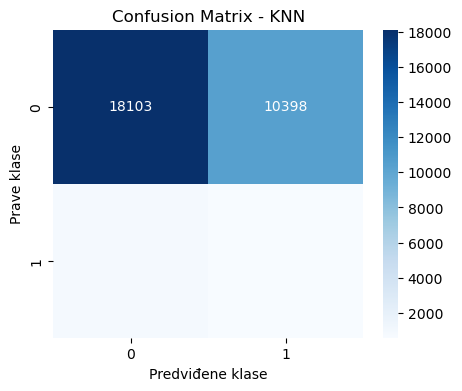

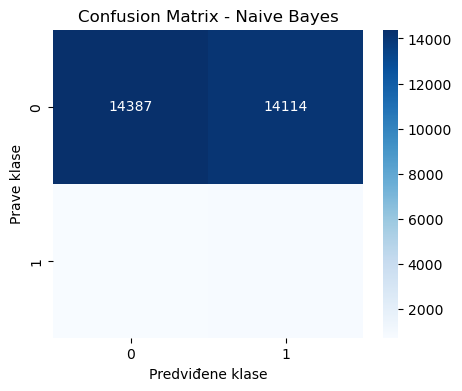

In [36]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predviđene klase')
    plt.ylabel('Prave klase')
    plt.show()

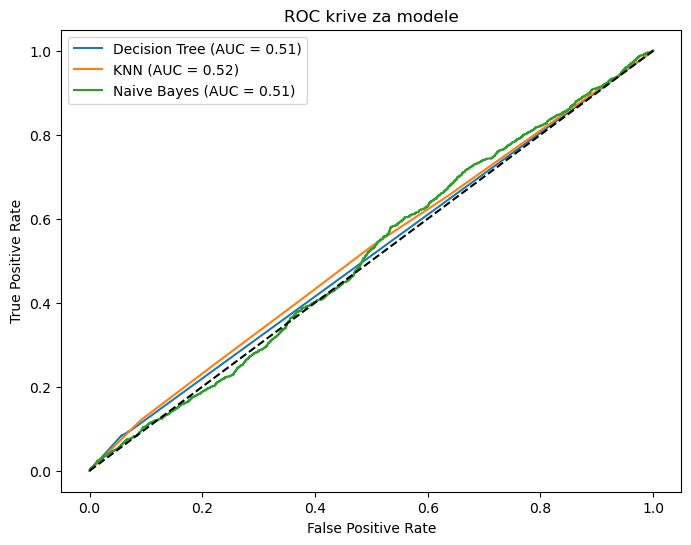

In [37]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]  # verovatnoće za klasu 1
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0,1], [0,1], 'k--')  # linija slučajne klasifikacije
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC krive za modele')
plt.legend()
plt.show()

In [38]:
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f'{name} - Cross-val F1-score: {scores.mean():.3f} (+/- {scores.std():.3f})')

Decision Tree - Cross-val F1-score: 0.079 (+/- 0.006)
KNN - Cross-val F1-score: 0.001 (+/- 0.001)
Naive Bayes - Cross-val F1-score: 0.097 (+/- 0.008)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_5220\2172918458.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_claims = df.groupby('starosna_grupa')['ClaimNb'].sum().reset_index()
c:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


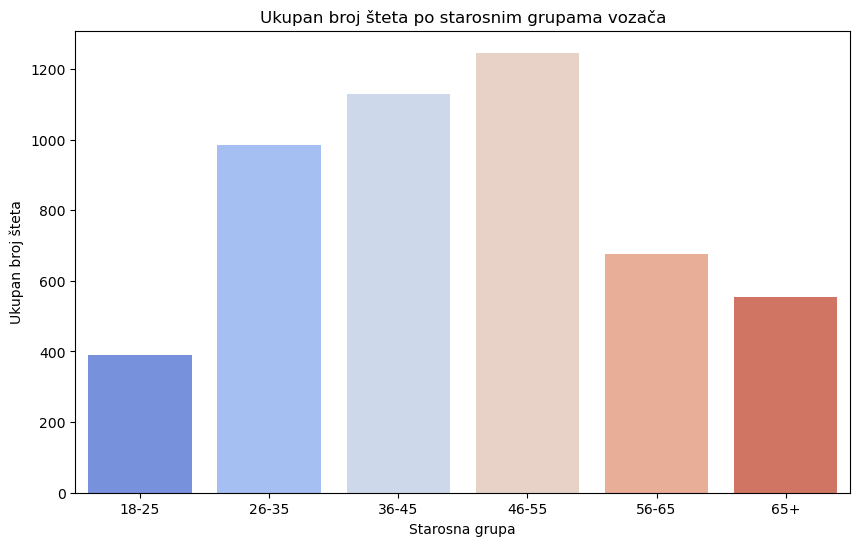

In [42]:
#gleda na celom skupu podataka
# Grupisanje po starosnim grupama i suma broja šteta
total_claims = df.groupby('starosna_grupa')['ClaimNb'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='starosna_grupa', y='ClaimNb', data=total_claims, palette='coolwarm')
plt.title("Ukupan broj šteta po starosnim grupama vozača")
plt.xlabel("Starosna grupa")
plt.ylabel("Ukupan broj šteta")
plt.show()

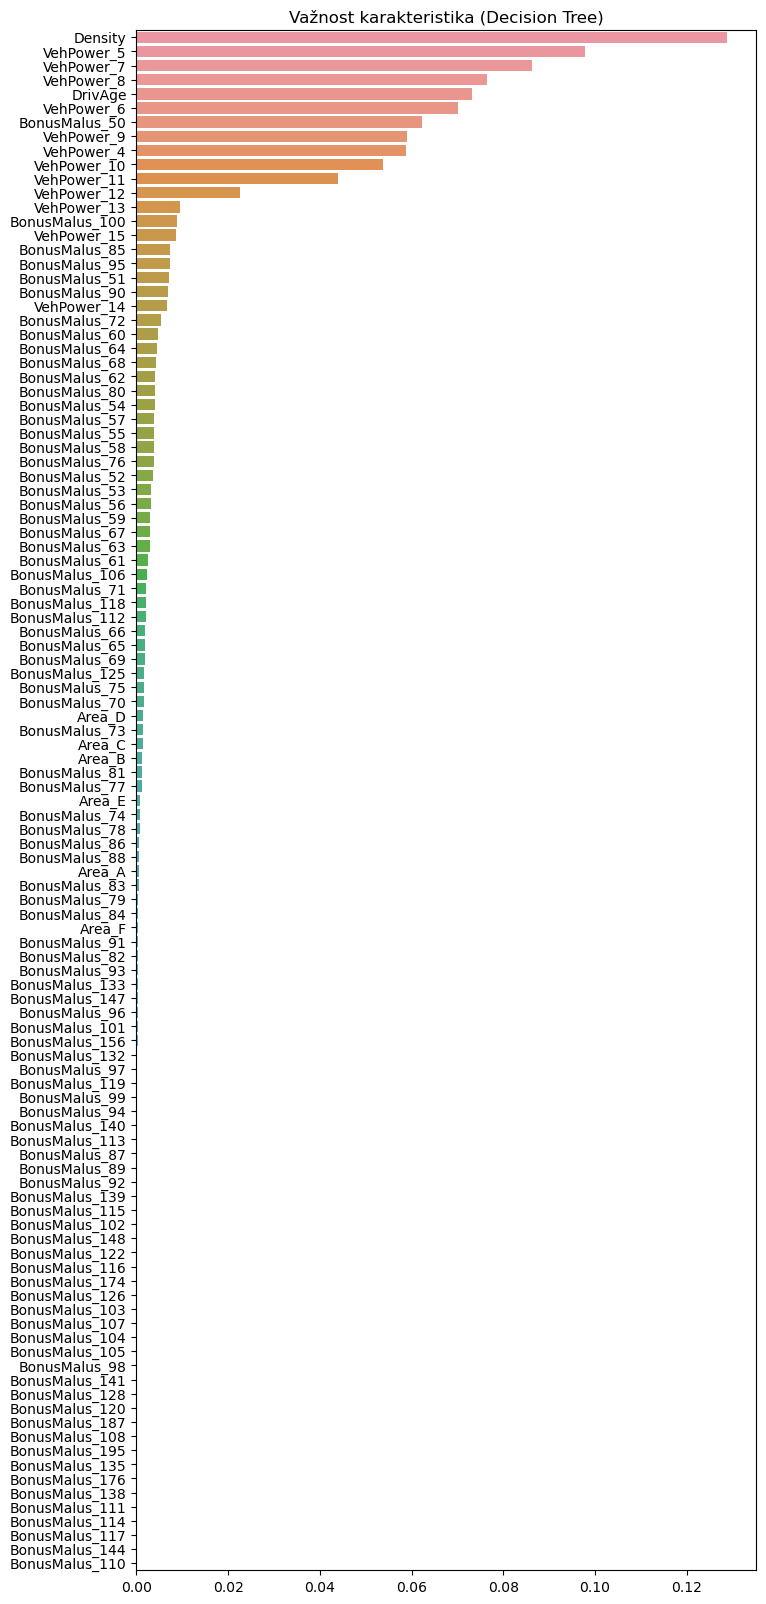

In [43]:
importances = dtc.feature_importances_
feat_importance = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,20))
sns.barplot(x=feat_importance.values, y=feat_importance.index)
plt.title('Važnost karakteristika (Decision Tree)')
plt.show()
